In [1]:
import spectro as spec
import spec_utils_alex  as specu

import numpy as np
import numpy.ma as ma

import fnmatch

import os
import re
import scipy as scy
from scipy.optimize import curve_fit,least_squares
from scipy.integrate import quad

from matplotlib.gridspec import GridSpec

from astropy.io import ascii, fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.special import legendre
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy import convolution
from astropy.wcs import WCS

from matplotlib import pyplot as plt
from matplotlib import rcParams, rc
from matplotlib.ticker import MaxNLocator

import CogFunctions as cog

import uncertainties as unc  
import uncertainties.unumpy as unumpy  
import uncertainties.umath as uncm

rc('xtick',labelsize=15)
rc('ytick',labelsize=15)
rc('font',family='serif', size=18)
rcParams['axes.linewidth'] = 1.5
rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (10, 7)

In [2]:
my_measurements=Table(names=('sightline', 'vel [km/s]','ion','wavelength', 'f', 'ew', 'ew_err', 'N_AOD', 'N_AOD_err'),
                      dtype=('str', 'float','str','float','float','float','float', 'float', 'float'))

# link directly to BOX where the most up to date data is
box = '/Users/ahamanowicz/Library/CloudStorage/Box-Box/METALZ/COADDS/'

fits_list = fnmatch.filter(os.listdir(box), '*coadd*.fits')
print(fits_list)

['SEXTANS-A-OB321_COS_coadd.fits', 'IC1613-62024_COS_coadd.fits', 'IC1613-A13_COS_coadd.fits', 'SEXTANS-A-OB326_COS_coadd.fits', 'SEXTANS-A-SA3_COS_coadd.fits', 'SEXTANS-A-SA2_COS_coadd.fits', 'IC1613-67559_COS_coadd.fits', 'IC1613-67684_COS_coadd.fits', 'SEXTANS-A-SA1_COS_coadd_LPall.fits', 'SEXTANS-A-SA1_COS_coadd.fits', 'LEO-P-ECG26_COS_coadd.fits', 'IC1613-B2_COS_coadd.fits', 'IC1613-64066_COS_coadd.fits', 'WLM-A15_COS_coadd.fits', 'IC1613-B11_COS_coadd.fits', 'SEXTANS-A-SA2_COS_coadd_LPall.fits', 'SEXTANS-A-OB521_COS_coadd.fits', 'IC1613-B3_COS_coadd.fits', 'IC1613-61331_COS_coadd.fits', 'SEXTANS-A-OB523_COS_coadd.fits', 'IC1613-C10_COS_coadd.fits', 'IC1613-B7_COS_coadd.fits', 'WLM-A11_COS_coadd.fits', 'SEXTANS-A-s3_COS_coadd.fits', 'SEXTANS-A-SA3_COS_coadd_LPall.fits']


In [3]:
sightlines_table = Table.read('METALZ-results.fits') # final results of column density and depletions measurements
sightlines_table.show_in_notebook()

idx,sightline,RA [hex],Dec [hex],RA [deg],Dec [deg],log(N_SII),log(N_FeII),N(HI),d(Fe),d(S)
0,IC1613-61331,01:05:0.200,+02:09:13.10,16.2508,2.1536,15.11 .. 0.13999999999988866,14.43 .. 0.2799999999998999,20.84 .. 0.03,-1.28 .. 0.28,-0.13 .. 0.14
1,IC1613-62024,01:05:0.6460,+02:08:49.26,16.2527,2.147,15.29 .. 0.4499999999998785,15.38 .. 0.4099999999998758,21.05 .. 0.03,-0.54 .. 0.41,-0.16 .. 0.45
2,IC1613-64066,01:05.20700,+02:09:28.10,16.3017,2.1578,15.42 .. 0.9199999999998649,14.62 .. 0.19999999999989804,20.88 .. 0.04,-1.13 .. 0.2,0.14 .. 0.92
3,IC1613-67559,01:05:4.7670,+02:09:23.19,16.2699,2.1564,15.1 .. 0.16999999999988802,14.32 .. 0.29999999999990123,20.47 .. 0.14,-1.02 .. 0.33,0.23 .. 0.22
4,IC1613-67684,01:05:4.900,+02:09:32.60,16.2704,2.1591,15.08 .. 0.1899999999998876,14.04 .. 0.3499999999999073,20.44 .. 0.04,-1.27 .. 0.35,0.24 .. 0.19
5,IC1613-A13,01:05:6.25,+02:10:43.0,16.276,2.1786,15.32 .. 1.3599999999998573,14.57 .. 0.389999999999894,20.26 .. 0.03,-0.56 .. 0.39,0.66 .. 1.36
6,IC1613-B11,01:04:43.8,+02:06:44.75,16.1825,2.1124,15.17 .. 0.3599999999998822,14.0 .. 0.4699999999999047,20.37 .. 0.05,-1.24 .. 0.47,0.4 .. 0.36
7,IC1613-B2,01:05:3.0680,+02:10:4.54,16.2628,2.1679,16.16 .. 3.7499999999997904,14.99 .. 0.3199999999998866,21.17 .. 0.03,-1.05 .. 0.32,0.59 .. 3.75
8,IC1613-B3,01:05:6.3700,+02:09:31.34,16.2765,2.1587,15.22 .. 0.26999999999988233,14.11 .. 0.21999999999990827,20.64 .. 0.06,-1.4 .. 0.23,0.18 .. 0.28
9,IC1613-B7,01:05:01.97,02:08:05.10,16.2582,2.1348,15.08 .. 0.35999999999988397,14.39 .. 0.21999999999990116,20.73 .. 0.03,-1.21 .. 0.22,-0.05 .. 0.36


In [4]:
ic1613 = sightlines_table[:10]
sexa = sightlines_table[10:]


In [12]:
Z_IC1613, Z_SexA = 0.13,0.08
HI = 1215.67
v_IC1613, v_SexA, v_WLM, v_LeoP = -233, 324, -130, 264

In [13]:
smoothing = Gaussian1DKernel(1)  # COS smoothing
# spectral smoothing
smoothing10 = Gaussian1DKernel(10)
smoothing5 = Gaussian1DKernel(5)
smoothing2 = Gaussian1DKernel(2)

In [14]:
# load HI spectra of the METAL-Z galaxies
hispec = ['IC1613_NA_ICL001.fits', 'SEXTANS-A_NA_ICL001.fits','WLM_NA_ICL001.fits']

# Line measurements

In [15]:
lines = np.loadtxt("line_list.txt", dtype='str')
print(lines)

[['0' 'FeII' '1142.366' '0.661']
 ['1' 'FeII' '1143.226' '1.342']
 ['2' 'FeII' '1144.938' '1.978']
 ['3' 'PII' '1152.818' '2.451']
 ['4' 'SiII' '1190.416' '2.541']
 ['5' 'SiII' '1193.290' '2.842']
 ['6' 'NI' '1199.550' '2.267']
 ['7' 'MgII' '1239.925' '-0.106']
 ['8' 'MgII' '1240.395' '-0.355']
 ['9' 'SII' '1250.578' '0.809']
 ['10' 'SII' '1253.805' '1.113']
 ['11' 'SII' '1259.518' '1.295']
 ['12' 'OI' '1302.168' '1.796']
 ['13' 'SiII' '1304.370' '2.052']
 ['14' 'NiII' '1317.217' '1.876']
 ['15' 'CII' '1334.532' '2.234']
 ['16' 'CuII' '1358.773' '2,569']
 ['17' 'NiII' '1370.132' '1.906']
 ['18' 'NiII' '1454.842' '1.672']
 ['19' 'SiII' '1526.707' '2.307']
 ['20' 'FeII' '1608.451' '1.968']
 ['21' 'FeII' '1611.200' '0.347']
 ['22' 'NiII' '1709.600' '1.743']
 ['23' 'NiII' '1741.549' '1.871']
 ['24' 'NiII' '1751.910' '1.686']
 ['25' 'SiII' '1808.013' '0.575']
 ['26' 'ZnII' '2026.136' '3.106']
 ['27' 'ZnII' '2062.664' '2.804']
 ['28' 'CrII' '2056.254' '2.326']
 ['29' 'CrII' '2066.161' '2.024

Fe II: 0,1,2,20,21,30,31 <br>
S II: 9,10, 11 <br>
Si II: 4,5,13,19,25. 5 strongest

# HI measurements

For each sightline you have to run this cell spearatelly changing the parameters. Run the HI fitting on each sightline and check the results

Fitting functions taken from Julia's spectro_utils repo, here I have added some changes.

In [37]:
def cont_fit_metal(sightline_no,vel_sys,line_no, vmin, vmax, sightlines_table, lines, order=3, save_spec=False, smooth=1):
    
    """
    lines=line table
    choose sightline - m - number form the table
    vmin, vmax - EW limits
    
    choose the line 
        Fe II: 0,1,2,20,21,30,31
        S II: 9,10, 11
    continuum fit velocity limits: 
    Fe II 1142, 1143, 1144:
    IC1613 -600 1200
    Sex A -500 1500
    """

    cont_min, cont_max = -600, 500
    
    smoothing = convolution.Gaussian1DKernel(smooth)  # COS smoothing
    m = sightline_no
    n = line_no
    vel = vel_sys
    ra,dec = sightlines_table['RA [deg]'][m], sightlines_table['Dec [deg]'][m]
    sightline = sightlines_table['sightline'][m]
    
    # spectrum file
    
    file ='/Users/ahamanowicz/Library/CloudStorage/Box-Box/METALZ/COADDS/' + sightline + '_COS_coadd.fits'
    hdul = fits.open(file)
    data = hdul[1].data

    w = data['WAVELENGTH']
    fx = np.array(data['FLUX'])
    es = np.array(data['ERROR'])

    fs = fx  # convolution.convolve(fx, smoothing)
    
    # get the systemic velocity for the sightline from SII lines
    
    lsii = 1250.578
    
    # determine the continuum near the sii line, normalize the spectrum, get the velocity components from the S II 1250 A line
    
    vel_sii, fn_sii, rmsn_sii, vc_sii, fc_sii = spec.find_components(w, fx, lsii, "CONT-FIT/" + sightline + '_sii_windows.dat',  smooth=5, outname='CONT-FIT/'+sightline+ '_sii_components', main_only=True, vsys=vel, outdir='./')
   
    vel = vc_sii[1]
    
    # get the line parameters 
    
    linename = lines.T[1][n]
    line = float(lines.T[2][n])
    line_f = float(lines.T[3][n])
    
    # continuum  fit
    # use plot_line_vel.py n to set the windows for fitting

    nanarray = np.isnan(fs) #mask nans in lfux
    notnan = ~ nanarray

    flux = fs[notnan]
    wav = w[notnan]
    err = es[notnan]
    
    cont = spec.cont_fit(w=wav, f=flux, line=line, window_file="CONT-FIT/" + sightline+'_line_' + str(n) + '_cont_win.txt',  degree = order, smooth = 1, outname = "CONT-FIT/" + sightline+'line_' + str(n) + '_fitting_cont_fit', plt_vmin = cont_min, plt_vmax =cont_max, outdir = './',spline=False, show=True)
    cont_err, cont_err_norm = specu.cont_fit_err(w=wav,f=flux,vsys=vel, line=line,window_file="CONT-FIT/" + sightline + '_line_'+str(n) + '_cont_win.txt', nord=order, smooth=1, vlim_down=cont_min, vlim_up=cont_max)
    
    print(sightline + '_line_' + str(n) + '_cont_win.txt')
    
    # continuum substraciton and spectral line cut
    # continuum corrected
    
    wav_cont, cont_fit = cont[0], cont[1]
    
    # move to the velocity of the line
    
    flux_cont = flux/cont_fit
    err_norm = err/cont_fit
    vel_cut,flux_cut = specu.cut_spec_window(wav, flux, line=line, vel=vel, veldown=cont_min,velup=cont_max, ra=ra,dec=dec)

    # cut for EW
    
    vel_cut,flux_cont_cut = specu.cut_spec_window(wav, flux_cont, line=line, vel=0, veldown=cont_min,velup=cont_max,ra=ra,dec=dec)
    vel_cut,flux_err_cut = specu.cut_spec_window(wav, err_norm, line=line, vel=0, veldown=cont_min,velup=cont_max, ra=ra,dec=dec)
    vel_cut,cont_cut = specu.cut_spec_window(wav, cont_fit, line=line, vel=0, veldown=cont_min,velup=cont_max,ra=ra,dec=dec)

    print(np.size(cont_err_norm), np.size(flux_cont_cut))

    if np.size(cont_err_norm) > np.size(flux_cont_cut):
        cont_err_norm = cont_err_norm[1:]
        cont_cut = cont_cut[1:]
        print("cont", np.size(cont_err_norm), np.size(flux_cont_cut), np.size(cont_cut))
        
    if np.size(cont_err_norm) < np.size(flux_cont_cut):
        flux_cont_cut = flux_cont_cut[1:]
        vel_cut =vel_cut[1:]
        cont_cut = cont_cut[1:]
        flux_err_cut = flux_err_cut[1:]
        print("flux", np.size(cont_err_norm), np.size(flux_cont_cut))

    wav_cut = (vel_cut) * line / 3.e5 + line
    data = np.stack((wav_cut,flux_cont_cut,flux_err_cut, cont_cut, cont_err_norm), axis=-1)
    ascii.write(data, sightline + '_' + linename + '_' + str(line) + "_cont.dat", overwrite=True, names=('wave','flux_norm','flux_err', "cont_fit", "cont_err"))
    
    plt.figure(figsize=(12, 7))
    plt.errorbar(vel_cut, flux_cont_cut, yerr=cont_err_norm, fmt='bo')
    plt.axhline(1.0, c='gray', ls='--') 
    plt.xlim([cont_min, cont_max])
    plt.ylim([0,1.5])
    
    plt.figure(figsize=(12, 7))
    plt.plot(vel_cut, flux_cont_cut, 'k-')
    plt.axhline(1.0, c='gray', ls='--') 
    plt.xlim([cont_min, cont_max])
    plt.ylim([0,1.5])
    
    print(sightline, round(vel, 3), linename, line, line_f)  # round(eq,3), eq_err,logN, N_err
    
    return sightline, np.round(vel, 3), linename, line, line_f  # np.round(eq,3), eq_err,np.round(logN,3), N_err

SEXTANS-A-SA2 ['SEXTANS-A-SA2_COS_coadd.fits', 'SEXTANS-A-SA2_COS_coadd_LPall.fits']


USING LEGENDRE


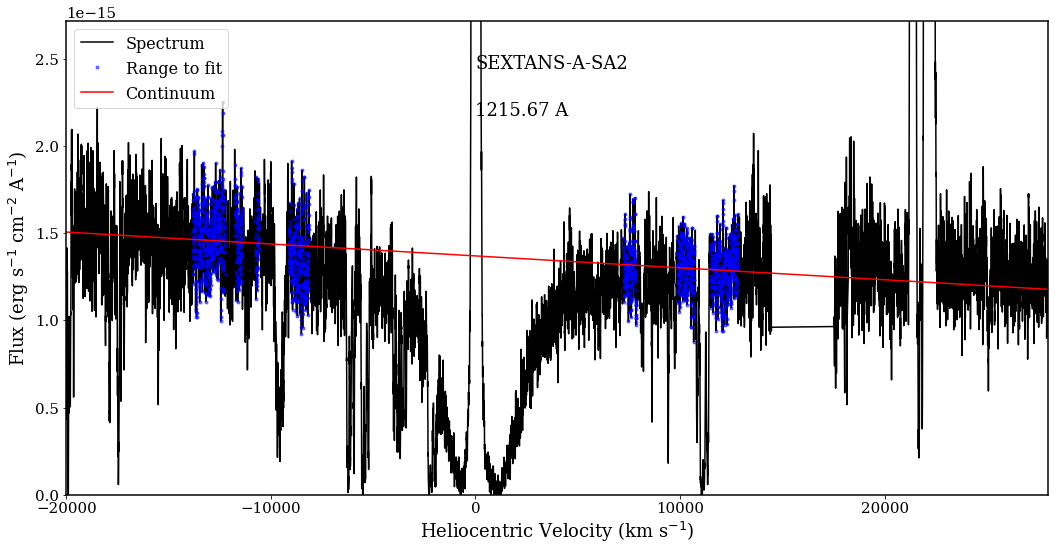

SCALING ERR  0.7006671958065078
TAU_MAX  100
TAU_MIN  0


/Users/ahamanowicz/Desktop/METAL-Z/notebooks/spectro.py:1411: RuntimeWarning: overflow encountered in exp
  correction = np.exp(tau_mw)*np.exp(tau_gal)
/Users/ahamanowicz/Desktop/METAL-Z/notebooks/spectro.py:1411: RuntimeWarning: overflow encountered in multiply
  correction = np.exp(tau_mw)*np.exp(tau_gal)


KeyboardInterrupt: 

In [33]:
# HI fitting: specify the gaalxy and systemic velocity
# requires: SII cont windows to measure velocity components: <sightline>_sii_windows.dat, in km/s, centered on MW
# continuum fit windows file: <sightline>_lyman_alpha_windows.dat, in km/s  centered on MW
# and fitting windows files: <sightline>_lyman_alpha_fit_windows.dat, in restframe A (Angstorm)


galaxy = 'Sextans A'
vsys = v_SexA

# choose the sightline
J = 16
sightline = sightlines_table['sightline'][J]
ra,dec = sightlines_table['RA [deg]'][J], sightlines_table['Dec [deg]'][J]

# find the spectrum
file = fnmatch.filter(os.listdir(box), "*" + sightline + "*.fits")
print(sightline, file)

# read the spectrum
hdul = fits.open(box + file[0])
data = hdul[1].data
wl = data['WAVELENGTH']
fx = np.array(data['FLUX'])
err = np.array(data['ERROR'])
fx_con10 = convolve(fx, smoothing10)
fx_con2 = convolve(fx, smoothing2)

# fit the HI
plt.figure(1, figsize=(15, 8))      
nhi = spec.nhi_fit_proc(spec_file=box + file[0], type_ascii = False,  target=sightline, smooth_sii = 5, 
            smooth_hi=8,outdir = './', tau_max = 100, show=True, tau_min=0, sampling = 0.01, vsys = vsys, 
            galaxy =galaxy, use_vsys=True, ra=ra, dec=dec)


# Continuum subtraction and creation of spectral snipets

USING LEGENDRE


VEL BOUNDARIES  -835 1367
TEST minima  [-802.0998    -792.5242    -787.751     -766.1984    -744.6752
 -739.90204   -732.7276    -708.80316   -694.4543    -684.8786
 -665.7566    -660.9834    -653.80896   -644.23334   -637.05896
 -627.48334   -620.3089    -613.13446   -603.5588    -586.838
 -582.0355    -567.6867    -562.9135    -558.1403    -541.39026
 -536.5878    -522.23895   -500.71573   -479.1925    -474.41928
 -462.4424    -457.66925   -452.89606   -443.3204    -438.5472
 -421.79715   -417.02396   -400.2739    -395.50073   -385.92508
 -381.1226    -371.57623   -362.00058   -352.42493   -347.65176
 -342.87854   -338.0761    -330.90167   -323.72726   -318.95407
 -297.43082   -283.082     -275.9076    -266.3319    -256.7563
 -251.9831    -244.80867   -237.63425   -230.45984   -213.70978
 -206.53535   -199.36095   -187.41335   -182.61087   -173.06451
 -165.89009   -158.71567   -153.91321   -146.73878   -129.98872
 -118.04112   -101.29105    -94.11664    -84.57027    -79.76781
  -67.8

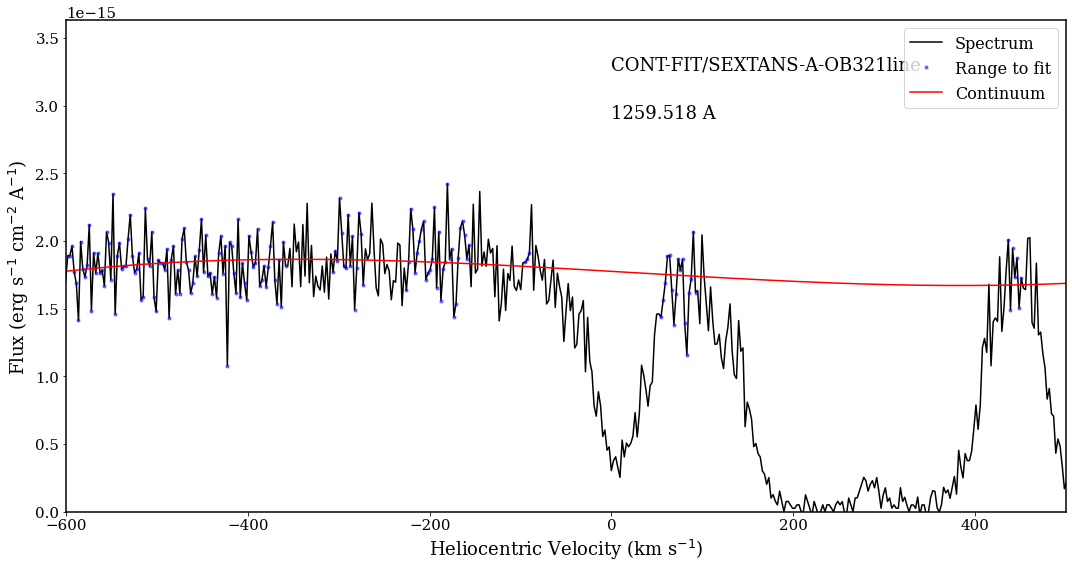

32192
463
SEXTANS-A-OB321_line_11_cont_win.txt
463 462
cont 462 462 461


ValueError: all input arrays must have the same shape

In [44]:
# Continuum correction: all sightlines in one go, per galaxy (change systemic velocity) and specify line
# continuum corrected snippets for Kirill
# continuum window files requred (*_cont_win.txt)
for i in range(10,18):
    line = cont_fit_metal(sightline_no=i,vel_sys=v_SexA, line_no=11, order=3, vmin=-50, vmax=50,
                            sightlines_table=sightlines_table, lines=lines, smooth=3)


From this point, notebook contains solutions for Equivalent Width measurements, which were not (eventually) used in the paper. 

# LSF missing flux percentage 
## Used with EqW code

In [12]:
# load COS LSF - avaliable  through MAST
lsf = np.loadtxt('../cos-lsf-lf4-1291.dat')

In [13]:
# load the reference file (disp)

hdul = fits.open("../METAL-Z-I/lsf/MAST_2022-01-06T1628/HST/reference/2bj2256ml_disp.fits")
data = hdul[1].data
t = Table(data)
lsfcoeff = t['COEFF'][19][1]
lsf0 = t['COEFF'][19][0] 

# G130M, FUV, 1291, LF=4, PSA

# Equivalent width measurements

### Run for each sightline separately

In [14]:
#using the strong line - SII 1253 or Fe II 1144 we set the limits (with automatic limits ) for all lines. 
# then we keep these limits for all other lines
# if the line is not detected we measure EW within the sma elimits and calculate 3 times the error
# for that I have to unpack the big measurement function.
#in the end we create the plot -> HI 21 cm, HI abs with fit, and all metal lines detected or not with EW marked (if limit do not plot the eqw fill in)


In [34]:
# choose sightline and find the spectral snippets

measurement = open("metalZ-ew-measurements2.txt", 'a')  # *2.txt to not mess up the original measurements - temp
i = 15
vel_gal = v_SexA
hi = 1
sightline = sightlines_table['sightline'][i]
ra,dec = sightlines_table['RA [deg]'][i], sightlines_table['Dec [deg]'][i]
print(sightline)

# get the files for the sightline
# find the files of spectral snippets

directory = '/Users/ahamanowicz/Library/CloudStorage/Box-Box/METALZ/METAL-Z_voigt/'
lst = os.listdir(directory)

files = os.listdir()

sii_files = [b for b in files if "dat" in b and "SII" in b and sightline in b]
feii_files = [b for b in files if "dat" in b and "FeII" in b and sightline in b]


# SII
line = 'SII'

sii_files = []
for b in lst:
    if 'dat' in b:
        if line in b:
            if sightline in b:
                sii_files.append(b)
                
#FeII
line = 'FeII'

feii_files = []
for b in lst:
    if 'dat' in b:
        if line in b:
            if sightline in b:
                feii_files.append(b)
                
print(sii_files, feii_files)
limsii, limfeii, limhi = 0, 0, 0
velsii, velfeii, velhi = 0, 0, 0

SEXTANS-A-SA1
['SEXTANS-A-SA1_SII_1259.518.dat', 'SEXTANS-A-SA1_SII_1253.805.dat', 'SEXTANS-A-SA1_SII_1250.578.dat'] ['SEXTANS-A-SA1_FeII_1608.451.dat', 'SEXTANS-A-SA1_FeII_1142.366.dat']


HI FILE  SEXTANS-A_NA_ICL001.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 152.753333333  -4.69277777778  
CRPIX : 1024.0  1025.0  
NAXIS : 2048  2048


-32.2426560673273


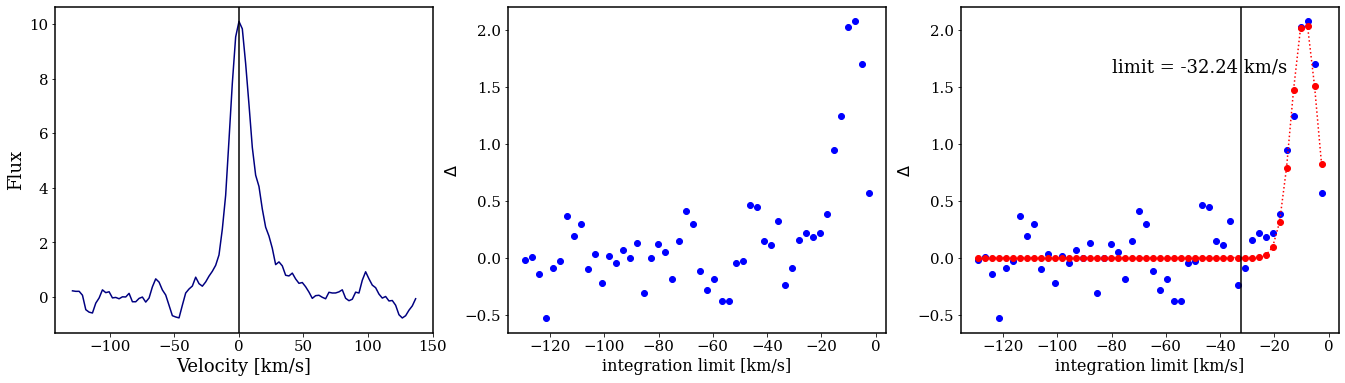

In [35]:
# get HI fine and find the velocity limits for EqW - Sextans A

velhi, spect = specu.get_hi_spectrum(ra_in=ra, dec_in=dec, hi_file=hispec[hi])
limhi, fighi = specu.hilimits(velhi, spect, vel_gal=311, alp=1, pos=False, sigmacut=5.)
fighi.savefig(sightline+"_HI.pdf")
print(limhi)

SEXTANS-A-SA1_SII_1250.578.dat
1250.578
clump velocity [311.85824777]
311.8582477654439


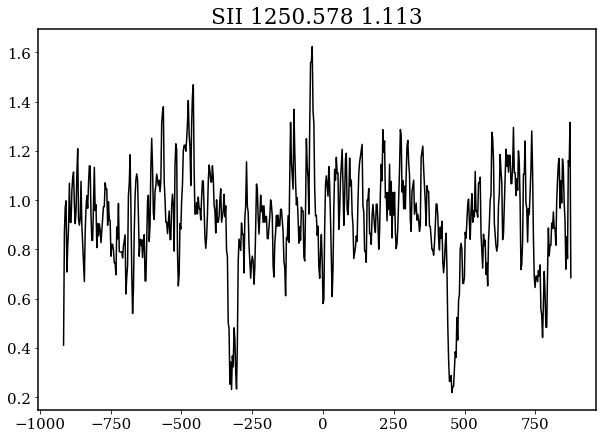

In [36]:
# Exact velocity of the line
# SII

line = 'SII'
j = 2
k=10
print(sii_files[j])

data = np.loadtxt(directory + sii_files[j], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
wav, flux, cont_err = data.T[0], data.T[1], data.T[3]

d = sii_files[j].split("_")
line0 = float(d[-1].split(".dat")[0])
print(line0)

vel = (wav-line0) / line0 * 3.e5
vel_lsr = spec.helio_to_lsr(vel,ra,dec)  # convert to lsr
f = convolve(flux, Box1DKernel(3))
velclump = specu.clump_velocity(vel_lsr, f, vel_gal=vel_gal, plot=False)
vel0 = vel_lsr - velclump  # corrected for local velocity of the galaxy
plt.plot(vel0, f, c='k')
plt.title(line + " " + str(line0) +  " " + lines.T[3][k])
velsii = velclump[0]
print(velsii)

W = 25.222+/-nan


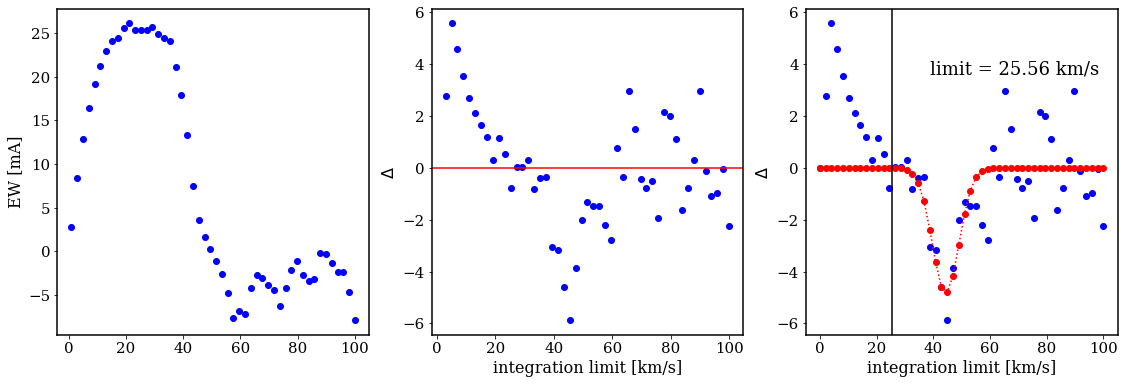

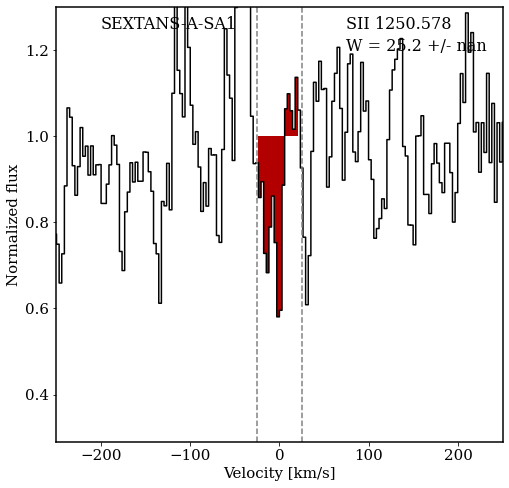

In [37]:
# eqw limits from absorption line works for IC1613 SII
# 120 usually works for S II 1259 in IC1613

eqw,ewqerr, limsii = specu.eqw_automatic_limits(vel0, f, cont_err=cont_err, 
                    sightline=sightline, velmax=100, sigmacut=4., linewav=line0, nbins=250, linename=line)
limfeii = 0

In [38]:
# manual velocity correction for WLM

line = "Fe II"
j = 0
k = 0
print(feii_files[j])

data = np.loadtxt(directory + feii_files[j], skiprows=1)
wav, flux, cont_err = data.T[0], data.T[1], data.T[3]

d = sii_files[j].split("_")
line0 = float(lines.T[2][k])
print(line0)

vel = (wav - line0) / line0 * 3.e5 
vel_lsr = spec.helio_to_lsr(vel,ra,dec)  # convert to lsr
f = convolve(flux, Box1DKernel(3))

velclump = specu.clump_velocity(vel_lsr, f, vel_gal=vel_gal, plot=False)
velfeii = velsii  # velclump[0] 
print(velfeii)
vel0 = vel_lsr - velfeii + v_SexA  # corrected for local velocity of the galaxy
plt.plot(vel0, f, c='k')
plt.title(line + " " + str(line0) + " " + lines.T[3][k])
plt.xlim([-600, 1200])

SEXTANS-A-SA1_FeII_1608.451.dat
1142.366


ValueError: zero-size array to reduction operation minimum which has no identity

ValueError: min() arg is an empty sequence

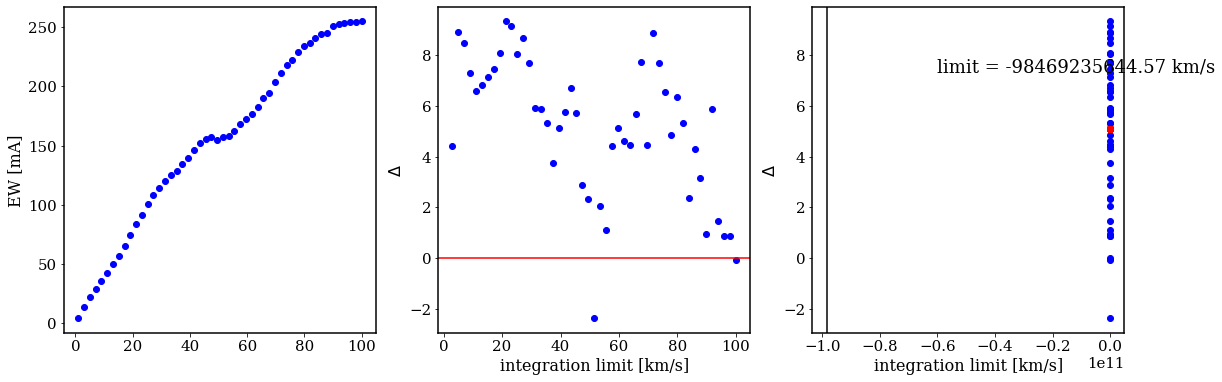

In [39]:
# ewq limits from Fe II
eqw,ewqerr, limfeii =specu.eqw_automatic_limits(vel0, f, cont_err=cont_err,sightline=sightline,nbins=250, velmax=100, linewav=line0, linename=line)

In [ ]:
# choose limits (which line)

limits = [limsii, limfeii, limhi]
velc = [velsii, velfeii, velsii]

# 0 - SII, 1 - FeII, 2 - HI

p = 2
lim = abs(limits[p])
vel_main = velc[p]

print(round(lim,2), round(vel_main, 3))  # km/s
print(vel_gal, velsii, velfeii)
save = True

In [ ]:
# apply chosen integration limit to all other metal lines
# read in spectra one by one measure eqw

flux_lsf = 0

# SII

velclump = velsii
print(sii_files)

line = 'SII'
for j in range(np.size(sii_files)):

    data = np.loadtxt(directory + sii_files[j], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
    wav, flux, cont_err = data.T[0], data.T[1], data.T[3]
    d = sii_files[j].split("_")
    line0 = float(d[-1].split(".dat")[0])
    print(line0)
    
    vel = (wav - line0) / line0 * 3.e5
    vel_lsr = spec.helio_to_lsr(vel, ra, dec)  # convert to lsr
    f = convolve(flux, Box1DKernel(3))
    velclump = specu.clump_velocity(vel_lsr, f, vel_gal=vel_gal, plot=False)
    vel0 = vel_lsr-velclump  # corrected for local velocity of the galaxy
    if j == 1 :
        velsii = velclump
    
    # calculate the flux lost to LFS wings
    flux_lsf = specu.plot_lsf(lsf,lsfcoeff, wav, f, velclump, lim, line, line0, sightline)
    print("lsf", flux_lsf)
        
    eqw, ewqerr = specu.eqw_with_err(vel0, f, cont_err=cont_err, sightline=sightline, vellim=lim, linewav=line0, linename=line)
    
    print(sightline, line, line0, round(eqw, 2), round(ewqerr,2), round(vel_main,3), round(lim,2),ra,dec)

    if save == True:
        measurement.write(sightline + " " + line + " " + str(line0) + " " + str(round(eqw, 2)) + " " + 
            str(round(ewqerr, 2)) + " 1 " + str(round(vel_main, 3)) + " " + str(round(lim, 2)) + " -99 " +
            str(ra) +  " " + str(dec) + " " + str(flux_lsf) + "\n")
            
        

In [40]:
# equivalent width
# FeII 

print(feii_files)
line = 'FeII'
velclump = velfeii - 20
print(velfeii)
# if no 1608
lim += 5
data = np.loadtxt(directory + feii_files[0], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
wav, flux, cont_err = data.T[0], data.T[1], data.T[3]


for line0 in [lines.T[2][0],lines.T[2][1],lines.T[2][2]]:


    line0 = float(line0)
    vel = (wav - line0) / line0 * 3.e5
    vel_lsr = spec.helio_to_lsr(vel,ra,dec)  # convert to lsr
    f = convolve(flux, Box1DKernel(3))
    vel0 = vel_lsr - velclump  # corrected for local velocity of the galaxy

    # for Sex-A FeII 1142 we need to add masking due to the contamination

    flux_lsf = specu.plot_lsf(lsf,lsfcoeff, wav, f, velclump, lim, line, line0, sightline)
    print("lsf", flux_lsf)

    eqw, ewqerr = specu.eqw_with_err(vel0, f, cont_err=cont_err, sightline=sightline, 
                                     vellim=lim, linewav=line0, linename=line)
    print(sightline, line, line0, round(eqw, 2), round(ewqerr, 2), round(vel_main, 3), round(lim, 2), ra, dec)

    if save == True:
        measurement.write(sightline + " " + line + " " + str(line0) + " " + str(round(eqw, 2)) +
            " " + str(round(ewqerr, 2)) + " 1 " + str(round(vel_main, 3)) + " " + str(round(lim, 2))+
            " -99 " + str(ra) + " " + str(dec) + " " + str(flux_lsf) + "\n")
                
            
if np.size(feii_files) > 1:
    
    data = np.loadtxt(directory + feii_files[1], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
    wav, flux, cont_err = data.T[0], data.T[1], data.T[3]
    line0 = float(lines.T[2][20])
    print(line0)
    
    vel = (wav - line0) / line0 * 3.e5
    vel_lsr = spec.helio_to_lsr(vel,ra,dec)  # convert to lsr
    f = convolve(flux, Box1DKernel(3))
    
    vel0 = vel_lsr - velclump  # corrected for local velocity of the galaxy
    eqw, ewqerr = specu.eqw_with_err(vel0, f, cont_err=cont_err, sightline=sightline, vellim=lim, linewav=line0, linename=line)
    
    print(sightline, line, line0, round(eqw, 2), round(ewqerr,2), round(vel_main,3), round(lim,2),ra,dec)
   
    if save == True:
        measurement.write(sightline + " " + line + " " + str(line0) + " " + str(round(eqw, 2)) +
            " " + str(round(ewqerr, 2)) + " 1 " + str(round(vel_main, 3)) + " " + str(round(lim, 2))+
            " -99 " + str(ra) + " " + str(dec) + " " + str(flux_lsf) + "\n")

    

['SEXTANS-A-SA1_FeII_1608.451.dat', 'SEXTANS-A-SA1_FeII_1142.366.dat']
0


NameError: name 'lim' is not defined

In [41]:
measurement.close()

In [42]:
# mask the Fe II 1142 for SexA

measurement = open("metalZ-ew-measurements2.txt", 'a')

print(feii_files)
line = 'FeII'
velclump = velfeii + 40

# chose the 1142

data = np.loadtxt(directory+feii_files[0], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
wav, flux, cont_err = data.T[0], data.T[1], data.T[3]

line0 = lines.T[2][0]
print(line0)
line0 = float(line0)

vel = (wav - line0) / line0 * 3.e5
vel_lsr = spec.helio_to_lsr(vel,ra,dec)  # convert to lsr
f = convolve(flux, Box1DKernel(3))
vel0 = vel_lsr - velclump  # corrected for local velocity of the galaxy

eqw,ewqerr = specu.eqw_with_err(vel0, f, cont_err=cont_err, sightline=sightline, 
                                vellim=lim, linewav=line0, linename=line)
print(sightline, line, line0, round(eqw, 2), round(ewqerr,2), round(vel_main,3), round(lim,2),ra,dec)

left_cut = -10
right_cut= 10

k = np.where((vel0 < lim) & (vel0 > -lim))
l = np.where((vel0 < lim) & (vel0 > left_cut))

# calculate the Ewq with new limits
eqw,ewqerr = specu.eqw_with_err(vel0, f, cont_err=cont_err, sightline=sightline, vellim=lim, 
                                velmask=left_cut, linewav=line0, linename=line, plot=False)

maskfig = plt.figure(2, figsize=(8,8))

plt.step(vel0, f, c='k')
plt.axvline(lim, ls='--', c='gray')
plt.axvline(-lim, ls='--', c='gray')
plt.axvline(left_cut, ls=':', c='k')
plt.fill_between(vel0[k], f[k],1,  fc='grey', step='pre', hatch='//')
plt.fill_between(vel0[k], f[k],1,  fc='grey', step='pre', hatch='//')
plt.fill_between(vel0[l], f[l],1,  fc='#b20000', step='pre')
plt.annotate(line + " " + str(line0), (0.65, 0.95), xycoords='axes fraction', fontsize=16 )
plt.annotate("W = " + str(round(eqw, 1)) + " +/- " + str(round(ewqerr, 1)), (0.65, .9), 
             xycoords='axes fraction', fontsize=16)
plt.annotate(sightline, (0.05, 0.95), xycoords='axes fraction', fontsize=16 )
plt.xlim([-250,250])
plt.ylim([min(f) * 0.75, 1.3])
plt.xlabel("Velocity [km/s]", fontsize=15)
plt.ylabel("Normalized flux", fontsize=15)

measurement.write(sightline + " " + line + " " + str(line0) + " " + str(round(eqw, 2)) + " " +
            str(round(ewqerr, 2)) +  " 1 " + str(round(vel_main, 3)) + " " + str(round(lim, 2)) + " " + 
            str(left_cut) + " " + str(ra) + " " + str(dec) + " " + str(flux_lsf) + "\n")

maskfig.savefig(sightline + "_" + line + "_" + str(line0) + "_eqw_mask.pdf")
measurement.close()

['SEXTANS-A-SA1_FeII_1608.451.dat', 'SEXTANS-A-SA1_FeII_1142.366.dat']
1142.366


NameError: name 'lim' is not defined

# Stack plot

In [43]:
from matplotlib.ticker import MaxNLocator, MultipleLocator

SEXTANS-A-SA2
['SEXTANS-A-SA2_SII_1250.578.dat', 'SEXTANS-A-SA2_SII_1259.518.dat', 'SEXTANS-A-SA2_SII_1253.805.dat']
1608
1250.578
[0]
1259.518
[2]
1253.805
[1]
['SEXTANS-A-SA1_FeII_1608.451.dat', 'SEXTANS-A-SA1_FeII_1142.366.dat']
1144.938
clump velocity [291.73093357]
[291.73093357]
[3]
1142.366
-30.0
1143.226
1144.938
1608.451
clump velocity [305.65799637]


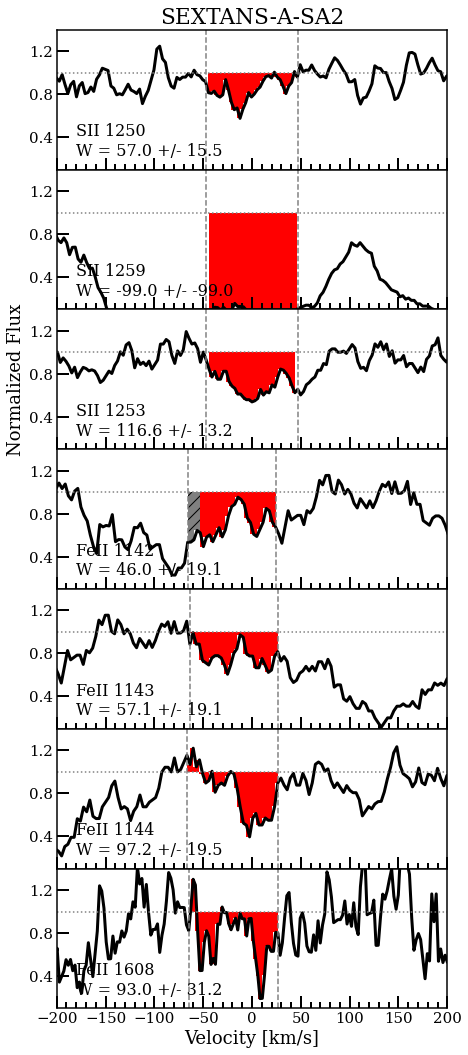

In [48]:
# all lines on one plot - Fe II limited (no 1608)

metalz = Table.read("METALZ-results.fits")
t = Table.read("metalZ-ew-measurements.txt", format='ascii')
i = 16  # sightline number
vel_gal = v_SexA, 
s = 5 
xlim = [-200, 200]

sightline = metalz['sightline'][i]
ra, dec = metalz['RA [deg]'][i], metalz['Dec [deg]'][i]
print(sightline)

# find the files of spectral snippets
directory = "/Users/ahamanowicz/Library/CloudStorage/Box-Box/METALZ/METAL-Z_voigt/"
lst = os.listdir(directory)

# SII
line = 'SII'

files = os.listdir()

sii_files = [b for b in files if "dat" in b and "SII" in b and sightline in b]

print(sii_files)

# to plot velocities we will use the same line as the velculp choices as the one used for limits. So for IC1613 -> SII 1529

# read a clump velocity from SI II 1259

a = np.where(t['sightline'] == sightline)
ta = t[a]
b = np.where(ta['linewav'] == float(lines.T[2][11]))[0]
velsii = ta['v_clump'][b][0]
vlim = ta['v_lim'][b][0]

n = 6
fe1608 = True
if i in [15,16,17]:
    print("1608")
    n = n + 1
    fe1608 = True
    
if vel_gal == v_SexA:
    n = n - 1
fig, axs = plt.subplots(n, 1, figsize=(7, 18), sharex=True)
fig.subplots_adjust(hspace = 0)

# SII lines

line = 'SII'
N = 3

if vel_gal == v_SexA:
    N = 2
    
for j, i in zip(range(N), range(0,N)):
    
    data = np.loadtxt(directory + sii_files[j], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
    wav, flux, cont_err = data.T[0], data.T[1], data.T[3]
    d = sii_files[j].split("_")
    line0 = float(d[-1].split(".dat")[0])
    print(line0)
    
    vel = (wav - line0) / line0 * 3.e5
    vel_lsr = spec.helio_to_lsr(vel,ra,dec)  # convert to lsr
    f = convolve(flux, Box1DKernel(s))
    vel0 = vel_lsr - velsii  # corrected for local velocity of the galaxy

    # choose the part used in EW calculations
    axs[i].plot(vel0, f, c='k', lw=3)
    k = np.where((vel0 > -vlim ) & (vel0 < vlim))[0]
    axs[i].fill_between(vel0[k], f[k],1,  fc='red', step='pre')

    # chose the Wr for print on plot
    d = np.where(ta['linewav'] == line0)[0]
    print(d)
    W, W_err = ta['Wr'][d][0], ta['Wr_err'][d][0]

    axs[i].annotate(line + " " + str(int(line0)) + "\nW = " + str(round(W, 1)) + " +/- "
                    + str(round(W_err, 1)), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )
    axs[i].axvline(vlim, ls='--', c='gray')
    axs[i].axvline(-vlim, ls='--', c='gray')
    axs[i].axhline(1, ls=':', c='gray')

# Fe II lines
print(feii_files)
line = 'FeII'


data = np.loadtxt(directory+feii_files[1], skiprows=1) # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
wav, flux, cont_err = data.T[0], data.T[1], data.T[3]

j=0
k=2

line0=float(lines.T[2][k])
print(line0)
vel = (wav-line0)/line0 * 3.e5
vel_lsr = spec.helio_to_lsr(vel,ra,dec ) #convert to lsr
f = convolve(flux, Box1DKernel(3))

velclump=specu.clump_velocity(vel_lsr, f, vel_gal=vel_gal, plot=False)
print(velclump)
if np.size(velclump) > 0:
    velfeii=velclump[0]
else: velfeii=velsii
mm = np.where(ta['linewav'] ==  1142.366)[0]
print(mm)
velfeii = velsii - 20


for line0, i in zip([lines.T[2][0],lines.T[2][1],lines.T[2][2]], range(N,n)):

    print(line0)
    line0=float(line0)
    vel = (wav-line0)/line0 * 3.e5
    vel_lsr = spec.helio_to_lsr(vel,ra,dec ) #convert to lsr
    f = convolve(flux, Box1DKernel(s))
    vel0 = vel_lsr-velsii # corrected for local velocity of the galaxy
    axs[i].plot(vel0, f, c='k', lw=3)

    vel0fe = vel_lsr-velfeii
    k = np.where((vel0fe > -vlim ) & (vel0fe< vlim))[0]
    delta = velsii-velfeii
    #axs[i].plot(vel0[k], f[k], c='red', lw=3)
    axs[i].fill_between(vel0[k], f[k],1,  fc='red', step='pre')
    if line0 == 1142.366:
        vmask = ta['v_masked'][mm][0] - delta
        print(vmask)
        l = np.where((vel0fe >= -vlim) & (vel0fe <= vmask))
        axs[i].fill_between(vel0[l], f[l],1,  fc='grey', step='pre', hatch='//')

    d = np.where(ta['linewav'] == line0)[0]
    W, W_err = ta['Wr'][d][0], ta['Wr_err'][d][0]

    if vel_gal == v_IC1613:
        if i == 4:

            axs[i].fill_between(vel0[k], f[k],1,  fc='red', step='pre', hatch='//')

    axs[i].annotate( line+ " " + str(int(line0))+"\nW = "+str(round(W,1))+" +/- "+str(round( W_err,1)), (0.05, 0.1), xycoords='axes fraction', fontsize=16 )
    axs[i].axvline(vel0[k[0]], ls='--', c='gray')
    axs[i].axvline(vel0[k[-1]], ls='--', c='gray')
    axs[i].axhline(1, ls=':', c='gray')

axs[-1].set_xlabel("Velocity [km/s]")
axs[2].set_ylabel("Normalized Flux")
axs[0].set_title(sightline)

if fe1608 == True:
    i = -1
    data = np.loadtxt(directory + feii_files[0], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
    wav, flux, cont_err = data.T[0], data.T[1], data.T[3]
    line0 = float(lines.T[2][20])
    print(line0)

    vel = (wav - line0) / line0 * 3.e5
    vel_lsr = spec.helio_to_lsr(vel,ra,dec)  # convert to lsr
    f = convolve(flux, Box1DKernel(3))
    velclump = specu.clump_velocity(vel_lsr, f, vel_gal=vel_gal, plot=False)
    vel0 = vel_lsr - velsii  # corrected for local velocity of the galaxy

    axs[i].plot(vel0, f, c='k', lw=3)

    vel0fe = vel_lsr - velfeii
    k = np.where((vel0fe > -vlim ) & (vel0fe < vlim))[0]
    delta = velsii - velfeii
    axs[i].fill_between(vel0[k], f[k],1,  fc='red', step='pre')

    d = np.where(ta['linewav'] == line0)[0]
    W, W_err = ta['Wr'][d][0], ta['Wr_err'][d][0]

    axs[i].annotate(line + " " + str(int(line0)) + "\nW = " + str(round(W, 1)) +
                    " +/- " + str(round(W_err, 1)), (0.05, 0.1), xycoords='axes fraction', fontsize=16)
    axs[i].axvline(vel0[k[0]], ls='--', c='gray')
    axs[i].axvline(vel0[k[-1]], ls='--', c='gray')
    axs[i].axhline(1, ls=':', c='gray')

for i in range(np.size(axs)):

    axs[i].set_xlim([-200,200])
    axs[i].yaxis.set_major_locator(MultipleLocator(0.4))  # added 
    axs[i].xaxis.set_minor_locator(MultipleLocator(10))
    axs[i].xaxis.set_major_locator(MultipleLocator(50))
    axs[i].set_ylim([0.1, 1.4])
    axs[i].tick_params(which='major', direction='in', length=12, width=2)
    axs[i].tick_params(which='minor', direction='in', length=6, width=2)

fig.savefig(sightline + "_line-stack.pdf")

# IC1613 Fe blending investigation

In [10]:
# the ratio of Fe lines to estimate fe 1142 from 1144
def W42(W44):
    
    fl42, fl44 = 10**0.661, 10**1.978
    l42, l44 = 1142.366, 1144.938
    eqw = W44 * fl42 / fl44 * l42 / l44
    
    return eqw

In [11]:
# the ratio of Fe lines to estimate fe 1142 from 1143
def W42_43(W43):
    
    fl42, fl43 = 10**0.661, 10**1.342
    l42, l43 = 1142.366, 1143.226
    eqw = W43 * fl42 / fl43 * l42 / l43
    
    return eqw

# IC1613 sightlines, calculate EW 1142 from CoG

In [12]:
fe = np.array([1142.366, 1143.226, 1144.938])
sii = 1253.805

In [218]:
blendT = open("blend-ICMW.txt", 'a')
blendT.write("sightline, MW-44, err, MW-43, err, blend, err, COG MW42, err, IC42, err\n")
blendT.close()

In [13]:
import line_blending as lb

In [244]:
def get_data(i):
    
    # i - sightline number
    box = '/Users/ahamanowicz/Library/CloudStorage/Box-Box/METALZ/COADDS/'

    p = box + sightlines_table['sightline'][i] + "_COS_coadd.fits"
    print(p)
    hdul = fits.open(p)
    data = hdul[1].data
    t = Table(data)
    
    return(t)

In [612]:
def spec_data(sightline_no=0):
    """ read Fe snpectral snippet (continuum normalized) for  articular sightline. 
        Return wav, flux and continuum error """

    sightline = sightlines_table['sightline'][sightline_no]
    print(sightline)
    
    # find the files of spectral snippets

    files = os.listdir("CONT-FIT/")
    feii_files = [b for b in files if "dat" in b and "FeII" in b and sightline in b]

    print(feii_files)
    
    data = np.loadtxt("CONT-FIT/" + feii_files[1], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
    wav, flux, cont_err = data.T[0], data.T[1], data.T[3]
    # plot the spectral snippet and mark all lines
    vel_gal = 0
    t = get_data(sightline_no)
    #lb.plot_fe_lines(sightline_no, t)
    
    return wav, flux, cont_err


In [613]:
def spec_center(wav, flux, sightline=0, line=0, vel_gal=0):
    """ Center the spectrum on the desired line.
        Return shifted velocity
        J - sightline no from sightlines-table 
        line - line number form lines table  0 - 1142, 1 - 1143, 2 - 1144"""
    J = sightline
    k = line
    
    ra, dec = sightlines_table['RA [deg]'][J], sightlines_table['Dec [deg]'][J]
   
    # read the line snippet data  (continuum normalized) and center at MW 1144
    fe = [1142.366, 1143.226, 1144.938, 1608.]
    
    line = 'FeII'
    line0 = fe[k]
    print(line0)
    #mocve spec to line velocity
    vel = (wav - line0) / line0 * 3.e5
    vel_lsr = spec.helio_to_lsr(vel, ra, dec)  # convert to lsr
    f = convolve(flux, Box1DKernel(3))
    velclump = specu.clump_velocity(vel_lsr, flux, vel_gal=vel_gal, plot=False)
    vel0 = vel_lsr - velclump  # corrected for local velocity of the galaxy
    
    plt.figure(figsize=(10,6))
    plt.plot(vel0, f, c='k')
    plt.title(line + " " + str(line0) + " " + lines.T[3][k])
    
    return vel0, f
    

In [614]:
def eqw_custom_limits(vel0,f, k = 0, vlim=50):
    """ Calculate equivalnet width of the line within user selected limits
    k - line number"""
    
    fe = [1142.366, 1143.226, 1144.938]
    print(fe[k])
    a = np.where((vel0 >= -300) & (vel0 <= 300))
    specu.eqw_simple(vel0[a], f[a], vmax=vlim, vmin=-vlim, line=fe[k])
    eqw = specu.eqw_with_err(wav=vel0[a], flux=f[a], cont_err=cont_err[a], 
                         vellim=vlim, velmask=0,linename='', linewav=fe[k],sightline='', nbins=100,
                         xlim=250, plot=True)
    return eqw

## measure W_1144 for MW

In [632]:
"""IC1613 deblended  EqW 1143. W measure EqW for 1143 and 1144 forr MW,calculate expected 1142 form MW 
then substract form the blended EqW (blend 1142 MW and 1143 IC 1613).
this way we get deblended EqW forn FeII 1143 inIC 1613
"""

#choose the sightline
J = 9
sightline = sightlines_table['sightline'][J]
wav, flux, cont_err = spec_data(J)


IC1613-B7
['IC1613-B7_FeII_1608.451.dat', 'IC1613-B7_FeII_1142.366.dat']
/Users/ahamanowicz/Library/CloudStorage/Box-Box/METALZ/COADDS/IC1613-B7_COS_coadd.fits


1144.938
clump velocity [-36.60261957]
1144.938


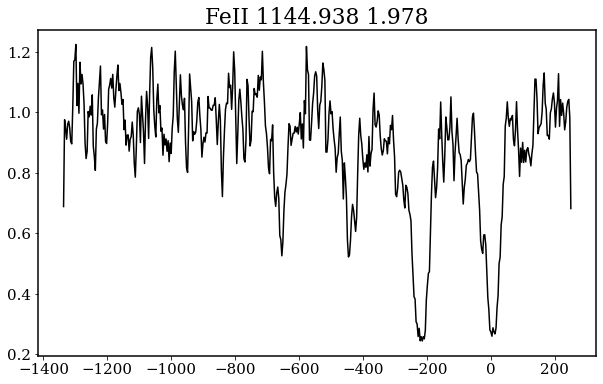

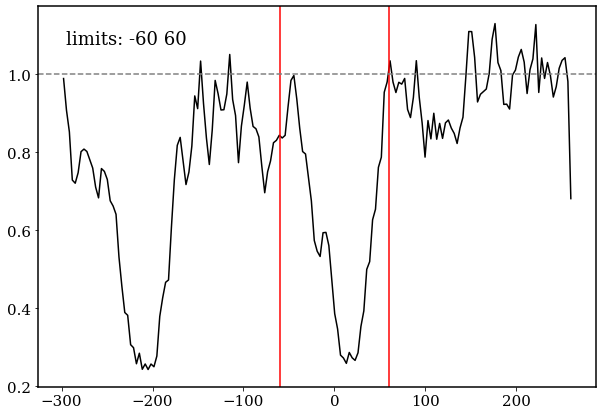

W = 180.417+/-23.933


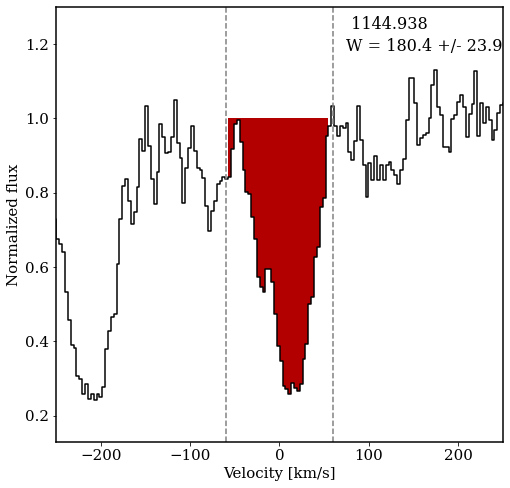

In [616]:
# Mw 1144
k = 2
vel0,f = spec_center(wav, flux,J,k) 
eqw_mw44 = eqw_custom_limits(vel0+10,f, k, vlim=60)

1143.226
clump velocity [-30.54201406]
1143.226


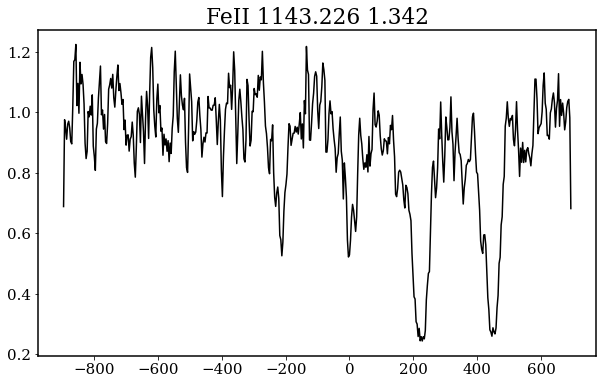

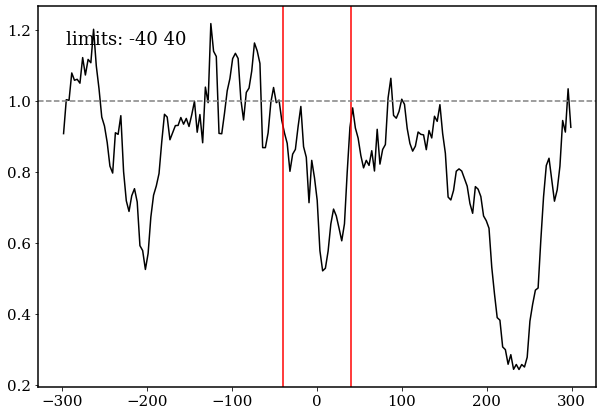

W = 75.158+/-16.255


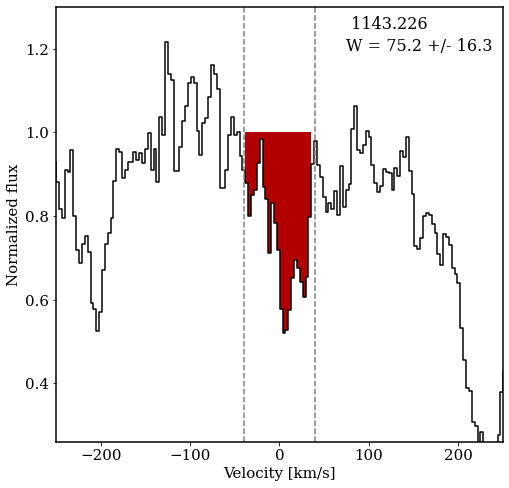

In [618]:
# Mw 1143
k = 1
vel0,f = spec_center(wav, flux,J, k) 
eqw_mw43 = eqw_custom_limits(vel0+10,f, k, vlim=40)

1143.226
clump velocity [-245.70846996]
1143.226


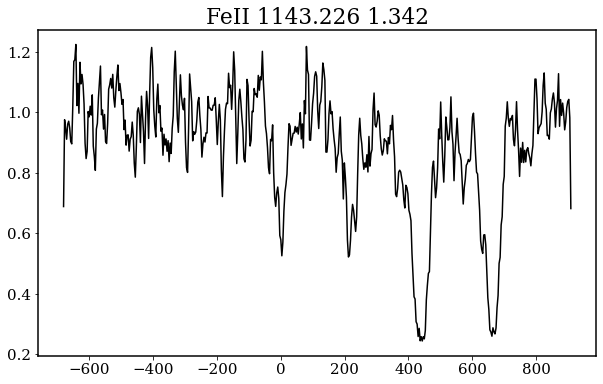

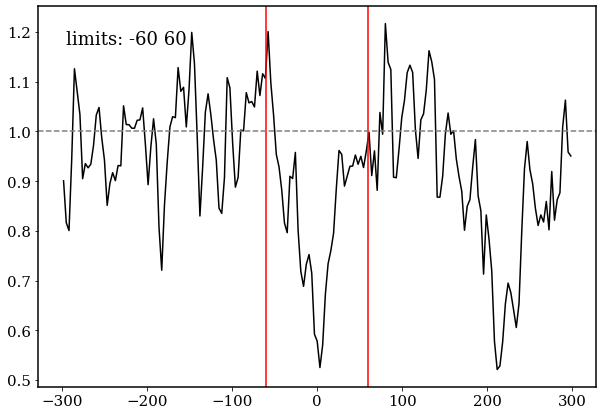

W = 68.83+/-11.837


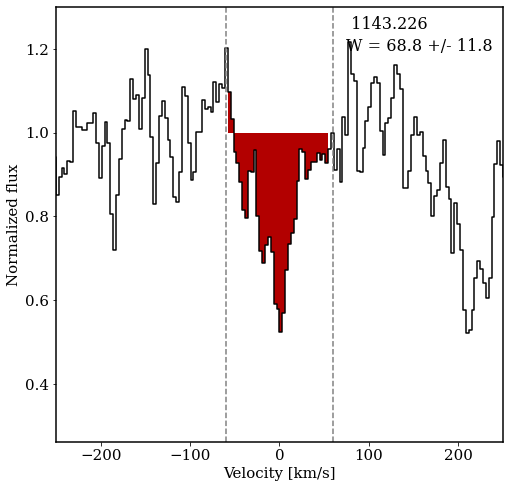

In [619]:
# EW of the Ic + Mw blend (1143 IC1613, 1142 MW)

k = 1
vel0, f = spec_center(wav, flux,J, k, vel_gal=v_IC1613) 
eqw_blend = eqw_custom_limits(vel0,f, k, vlim=60)

[1.342 1.978]
[-4.18215595 -3.8025049 ]


(-5.0, -3.0)

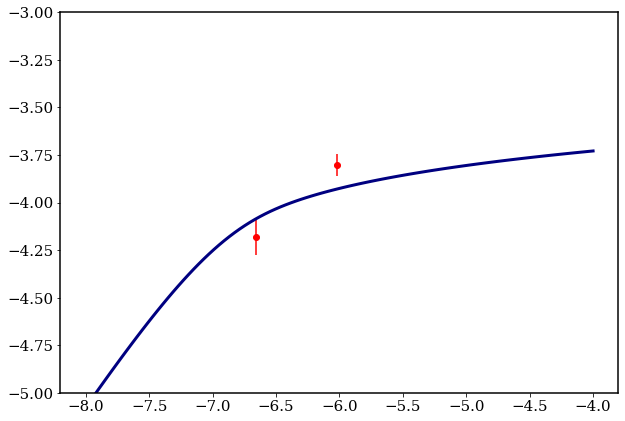

In [620]:
## MW 1144 are slightly saturated, to get 1142 we have to run CoG
# measure COG 

model_cube = fits.open('../model_00101.fits')  # in the model LF is in cm 
Model_array = model_cube[0].data

# the banana plot, error estimation 
N = np.arange(10, 20, .01)  # logN 10 - 20 
b = np.arange(5, 100, .1)  # 5 - 100
LF_m = np.linspace(-8, -4, 100)

# table of f values (Morton) 

ffeii = np.array([0.661 ,1.342, 1.978])  # Fe II 1142, 1143, 1144, 1608 -1.968
lf = ffeii[1:]
print(lf)
lfeII = np.array([1142.366, 1143.226, 1144.938])
Nguess, bguess = 15, 10
W = cog.CoG_full(Nguess, bguess, LF_m)

w0 = np.array([eqw_mw43[0], eqw_mw44[0]])
w0_err = np.array([eqw_mw43[1], eqw_mw44[1]])
eqw = unumpy.uarray(w0, w0_err)
yplot = unumpy.log10(eqw / 1000. / lfeII[1:])

x= lf - 8  # move to cm
print(unumpy.nominal_values(yplot))
plt.errorbar(x, unumpy.nominal_values(yplot), yerr=unumpy.std_devs(yplot), fmt='ro')
plt.plot(LF_m, np.log10(W), c = 'navy', lw=3)
plt.ylim([-5.0, -3.0])


In [621]:
y = w0 / 1000. / lfeII[1:]  # y = W/labmda
yerr = w0_err / 1000. / lfeII[1:]

# find the N by comparing to the model
S = np.zeros((np.shape(Model_array)[2], np.shape(Model_array)[1]))
L = np.zeros((np.shape(Model_array)[2], np.shape(Model_array)[1]))
for i in range(np.shape(Model_array)[2]):

    for j in range(np.shape(Model_array)[1]):
        s_sum = 0
        
        for w,s, l in zip(y, yerr, x):
   
            # find the lf in the model closest to the datapoint
            delta_l = np.abs(LF_m - l) 
            idx = np.argmin(delta_l)
            #print(idx)
            model = Model_array[idx][j][i] # model index lf, b, N
                       
            s_k = (w - 10**model)**2/(s)**2        
            s_sum += s_k
    
        S[i][j] = s_sum
        L[i][j] = np.exp(-s_sum/2.)
        
S_min = np.min(S)

Chi_r = S #/(np.size(w0)-2) #skipping te reduced chi
print(np.min(Chi_r))

0.0006321438721169935


In [622]:
# select best fitting parameters
index = np.where(Chi_r == np.min(Chi_r))
print(N[index[0]], b[index[1]]) #minimal chi

min_chi=np.min(Chi_r)
nbest,bbest = N[index[0]], b[index[1]]
nbest = round(nbest[0],2)
bbest = round(bbest[0],2)

#error 
Lmax = np.max(L)
ni = np.where(Y >= 0.32 * Lmax)  # all larger the 1 sigma confidence
bi = np.where(X >= 0.32 * Lmax)

bmin, bmax = round(np.min(b[bi]), 2), round(np.max(b[bi]), 2)
nmin, nmax = round(np.min(N[ni]), 2), round(np.max(N[ni]), 2)

print(bmin, bbest, bmax, bmin - bbest, bmax - bbest)
print(nmin, nbest, nmax, nmin - nbest, nmax - nbest)

bdo, bup = round(-bmin + bbest, 2), round(bmax - bbest, 2)
ndo, nup = round(-nmin + nbest, 2), round(nmax - nbest, 2)

#plot the fitted CoG and find the MW 1142 eqw
W = cog.CoG_full(nbest,bbest,LF_m)

# find the errors
W_up = cog.CoG_full(nmax,bbest,LF_m)
W_down =  cog.CoG_full(nmin,bbest,LF_m)

[14.64] [19.3]
12.1 19.3 25.9 -7.200000000000001 6.599999999999998
14.53 14.64 14.98 -0.11000000000000121 0.33999999999999986


18.545508944789784 11.820164185065092


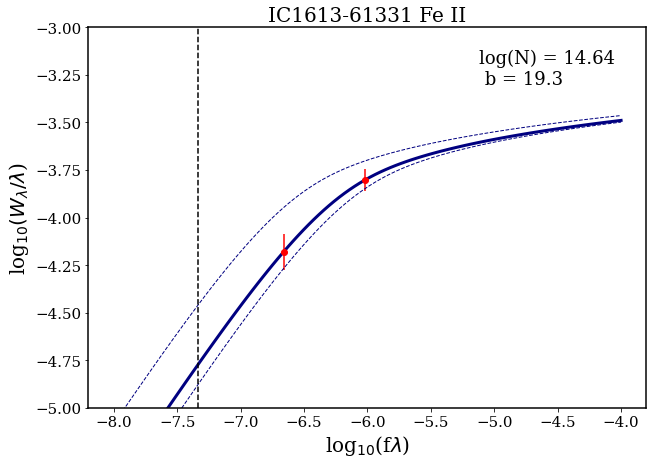

In [623]:
# EqW 1142 MW
d = abs(LF_m - (ffeii[0] - 8))
g = np.where(d == np.min(d))[0][0]

fig = plt.figure()
plt.errorbar(x,unumpy.nominal_values(yplot), yerr=unumpy.std_devs(yplot), fmt='ro')
plt.plot(LF_m,np.log10(W), c = 'navy', lw=3)
plt.plot(LF_m,np.log10(W_up), c = 'navy', lw=1, ls='--' )
plt.plot(LF_m,np.log10(W_down), c = 'navy', lw=1, ls='--' )
plt.ylim([-5.0, -3.0])
plt.xlabel(r"log$_{10}$(f$\lambda$)", fontsize=20)
plt.ylabel(r"log$_{10}(W_{\lambda} / \lambda$)", fontsize=20)
plt.annotate("log(N) = "+ str(nbest) + "\n b = "+ str(bbest), (0.7,0.85), xycoords='axes fraction')
plt.title(name + " "+line, fontsize=20)
plt.axvline(ffeii[0]-8, ls='--', c='k')
fig.savefig(sightline+"MWIC-blend_cog.png")

eqw_mw42 = W[g]*lfeII[0] * 1000

#err 
eqw_mw42_err = np.mean([(W[g] - W_down[g]), (W_up[g]-W[g])])*lfeII[0] * 1000

print(eqw_mw42, eqw_mw42_err)  #use mean for th error...

In [624]:
#finally the IC1613 1143 deblended
eqw_ic43 = eqw_blend[0] - eqw_mw42
eqw_ic43_err = np.sqrt(eqw_blend[1]**2 + eqw_mw42_err**2)

In [625]:
print(f"{sightline} MW-44 {eqw_mw44[0]:.2f} +/- {eqw_mw44[1]:.2f} MW-43 {eqw_mw43[0]:.2f} +/- {eqw_mw43[1]:.2f}\n\
blend {eqw_blend[0]:.2f} +/- {eqw_blend[1]:.2f}\n\
COG MW 1142 {eqw_mw42:.2f} +\- {eqw_mw42_err:.2f}\n\
IC-43 {eqw_ic43:.2f} +\- {eqw_ic43_err:.2f}")

IC1613-B7 MW-44 180.42 +/- 23.93 MW-43 75.16 +/- 16.26
blend 68.83 +/- 11.84
COG MW 1142 18.55 +\- 11.82
IC-43 50.28 +\- 16.73


In [626]:
l = f"{sightline} & {eqw_mw44[0]:.2f} $\pm$ {eqw_mw44[1]:.2f} & {eqw_mw43[0]:.2f} $\pm$ {eqw_mw43[1]:.2f}\
 & {eqw_blend[0]:.2f} $\pm$ {eqw_blend[1]:.2f} & {eqw_mw42:.2f} $\pm$ {eqw_mw42_err:.2f}\
 & {eqw_ic43:.2f} $\pm$ {eqw_ic43_err:.2f} \\\ "

In [627]:
print(l)

IC1613-B7 & 180.42 $\pm$ 23.93 & 75.16 $\pm$ 16.26 & 68.83 $\pm$ 11.84 & 18.55 $\pm$ 11.82 & 50.28 $\pm$ 16.73 \\ 


In [628]:
blend_tab += l

In [629]:
print(blend_tab)

IC1613-61331 & 180.47 $\pm$ 19.22 & 82.68 $\pm$ 14.71 & 68.79 $\pm$ 9.51 & 21.48 $\pm$ 11.66 & 47.31 $\pm$ 15.05 \ IC1613-62024 & 184.24 $\pm$ 18.82 & 80.53 $\pm$ 15.10 & 113.66 $\pm$ 14.33 & 20.64 $\pm$ 11.76 & 93.02 $\pm$ 18.54 \ IC1613-64066 & 163.44 $\pm$ 19.64 & 66.98 $\pm$ 15.85 & 89.38 $\pm$ 12.85 & 16.55 $\pm$ 11.66 & 72.82 $\pm$ 17.35 \ IC1613-67559 & 163.48 $\pm$ 18.55 & 79.92 $\pm$ 13.63 & 59.84 $\pm$ 11.28 & 21.70 $\pm$ 11.35 & 38.14 $\pm$ 16.00 \ IC1613-67684 & 161.79 $\pm$ 15.77 & 78.65 $\pm$ 14.14 & 39.11 $\pm$ 8.55 & 21.24 $\pm$ 11.34 & 17.88 $\pm$ 14.20 \ IC1613-A13 & 170.19 $\pm$ 19.28 & 78.78 $\pm$ 16.82 & 75.36 $\pm$ 12.36 & 20.49 $\pm$ 11.53 & 54.87 $\pm$ 16.91 \IC1613-B11 & 178.22 $\pm$ 18.73 & 119.34 $\pm$ 16.32 & 42.31 $\pm$ 12.91 & 43.42 $\pm$ 11.10 & -1.11 $\pm$ 17.03 \\ IC1613-B2 & 164.71 $\pm$ 19.45 & 107.58 $\pm$ 20.78 & 126.40 $\pm$ 13.87 & 37.60 $\pm$ 10.95 & 88.80 $\pm$ 17.68 \\ IC1613-B3 & 143.99 $\pm$ 16.64 & 42.72 $\pm$ 12.53 & 9.55 $\pm$ 12.26 & 9.39

In [630]:
blendT = open("blend-ICMW.txt", 'a')

blendT.write(sightline + ' , ' + str(eqw_mw44[0]) + ' , ' + str(eqw_mw44[1]) + ' , ' +  str(eqw_mw43[0]) +
' , ' + str(eqw_mw43[1]) + ' , ' + str(eqw_blend[0]) + ' , ' + str(eqw_blend[1]) + ' , ' + 
str(eqw_mw42) + ' , ' + str(eqw_mw42_err) + ' , ' + str(eqw_ic43) + ' , ' + str(eqw_ic43_err) + '\n')
blendT.close()

In [502]:
#load the reference file (disp)
hdul=fits.open("../METAL-Z-I/lsf/MAST_2022-01-06T1628/HST/reference/2bj2256ml_disp.fits")
data=hdul[1].data
t = Table(data)
lsfcoeff=t['COEFF'][19][1]
lsf0 = t['COEFF'][19][0] 
#G130M, FUV, 1291, LF=4, PSA

## EW measurements

In [ ]:
## compare measurements with Ed
#read in Ed'S file

#EDs measurements
metal_meas = Table.read("IC1613-EJ.txt", format='ascii')
edmes = Table(metal_meas, names=["sightline", "grating", "wavelenght", "f", "line", "Wr", "Wr_err", "log(N)","logN_err", "logN_err2", "logN_err3", "logN_err4", "logN_err5"]) 
# metal_table=Table([metal_meas['sightline'],metal_meas['element'], metal_meas['wavelength'], metal_meas['ew'], metal_meas['err_ew'], metal_meas['logN']])
# print(metal_table)
edmes.show_in_notebook()

In [ ]:
#read in the measurements file
#my measurements
#flag: 1- good measurmeent, 0 - limit, -1 - bad measurement
metalz = Table.read("metalZ-ew-measurements.txt", format='ascii')
#MZmes = Table(metalz)#, names=["sightline", "line", "linewav", "Wr", "Wr_err", "flag", "v_clump", "v_lim", "ra", "dec"]) 
# metal_table=Table([metal_meas['sightline'],metal_meas['element'], metal_meas['wavelength'], metal_meas['ew'], metal_meas['err_ew'], metal_meas['logN']])
# print(metal_table)
MZmes = metalz[:63]
MZmes.show_in_notebook()


In [ ]:
sii = np.where(MZmes['line']=='SII')[0]
siied = np.where(edmes['line']=='SII')[0]

feii = np.where(MZmes['line']=='FeII')[0]
feiied = np.where(edmes['line']=='FeII')[0]

In [ ]:
sii_MZ = MZmes[sii]
sii_ed = edmes[siied]
sii_ed.show_in_notebook()

feii_MZ = MZmes[feii]
feii_ed = edmes[feiied]

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.hist(sii_ed['Wr'])
plt.hist(sii_MZ['Wr'],histtype='step', lw=3)
plt.subplot(122)
plt.hist(feii_ed['Wr'])
plt.hist(feii_MZ['Wr'],histtype='step', lw=3)

In [ ]:
amz = np.where(sii_MZ['linewav'] == 1250.578)[0]
bmz = np.where(sii_MZ['linewav'] == 1253.805)[0]
cmz = np.where(sii_MZ['linewav'] == 1259.518)[0]

afmz = np.where(feii_MZ['linewav'] == 1142.366)[0]
bfmz = np.where(feii_MZ['linewav'] == 1143.226)[0]
cfmz = np.where(feii_MZ['linewav'] == 1144.938)[0]

aed = np.where(sii_ed['wavelenght'] == 1250.578)[0]
bed = np.where(sii_ed['wavelenght'] == 1253.805)[0]
ced = np.where(sii_ed['wavelenght'] == 1259.518)[0]

afed = np.where(feii_ed['wavelenght'] == 1142.366)[0]
bfed = np.where(feii_ed['wavelenght'] == 1143.226)[0]
cfed = np.where(feii_ed['wavelenght'] == 1144.938)[0]

In [ ]:
feii_nob11 = feii_MZ[afmz]
bb= np.where(feii_MZ['sightline'] !='IC1613-B11' )


In [ ]:
sii_ed[ced]

In [ ]:
sii_MZ[cmz]

In [ ]:
sii_ed[ced]

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(sii_MZ['Wr'][amz],sii_ed['Wr'][aed][:-1], fmt='bo', label='SII 1250', xerr =sii_MZ['Wr_err'][amz],yerr =sii_ed['Wr_err'][aed][:-1], elinewidth=1 )
plt.errorbar(sii_MZ['Wr'][bmz],sii_ed['Wr'][bed][:-1], fmt='ro', label='SII 1253', xerr =sii_MZ['Wr_err'][bmz],yerr =sii_ed['Wr_err'][bed][:-1], elinewidth=1)
plt.errorbar(sii_MZ['Wr'][cmz],sii_ed['Wr'][ced][:-1], fmt='go', label='SII 1259', xerr =sii_MZ['Wr_err'][cmz],yerr =sii_ed['Wr_err'][ced][:-1], elinewidth=1)
plt.plot(np.linspace(0,300),np.linspace(0,300), ls='-', lw=2, c='k')
plt.xlabel("METAL-Z measurements (Alex)")
plt.ylabel("METAL-Z measurements (Ed)")
plt.legend(fontsize=12)
plt.xlim([0,200])
plt.ylim([0,200])

In [ ]:
feii_MZ[bfmz][:6]

In [ ]:
feii_MZ[cfmz][6:]

In [ ]:
plt.figure(figsize=(7,7))
plt.errorbar(feii_MZ['Wr'][afmz][:6],feii_ed['Wr'][afed][0:6], fmt='bo', label='FeII 1142', xerr =feii_MZ['Wr_err'][afmz][:6],yerr =feii_ed['Wr_err'][afed][:6], elinewidth=1 )
plt.errorbar(feii_MZ['Wr'][afmz][7:],feii_ed['Wr'][afed][6:], fmt='bo', xerr =feii_MZ['Wr_err'][afmz][7:],yerr =feii_ed['Wr_err'][afed][6:], elinewidth=1 )

plt.errorbar(feii_MZ['Wr'][cfmz],feii_ed['Wr'][cfed][:-1], fmt='ro', label='FeII 1144', xerr =feii_MZ['Wr_err'][cfmz],yerr =feii_ed['Wr_err'][cfed][:-1], elinewidth=1 )

# plt.errorbar(feii_MZ['Wr'][bmz],feii_ed['Wr'][bmz], fmt='ro', label='FeII 1143', xerr =feii_MZ['Wr_err'][bmz],yerr =feii_ed['Wr_err'][bmz], elinewidth=1)
# plt.errorbar(feii_MZ['Wr'][cmz],feii_ed['Wr'][cmz], fmt='go', label='FeII 1144', xerr =feii_MZ['Wr_err'][cmz],yerr =feii_ed['Wr_err'][cmz], elinewidth=1)
plt.plot(np.linspace(-20,300),np.linspace(-20,300), ls='-', lw=2, c='k')
plt.xlabel("METAL-Z measurements (Alex)")
plt.ylabel("METAL-Z measurements (Ed)")
plt.legend(fontsize=12)
plt.xlim([0,250])
plt.ylim([0,250])